# Разработка модели предсказывающий коэффициент восстановления золота из золотосодержащей руды
**Сборный проект Яндекс.Практикум - Data Science**

## Описание проекта

**Исходные данные:**

Сырые данные технологического процесса (данные с параметрами добычи и очистки) по получению полезных ископаемых из руды.

**Цель проекта:**

Построить модель предсказывающую коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Условия задачи:**

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

<img alt="image" class="image image_expandable"  width="80%" height="80%" src="https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg">

Стадии очистки:
1. Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Структура проекта
* [1. Подготовка данных](#start)
* [2. Анализ данных](#eda)
    * [2.1 Концентрация металлов (Au, Ag, Pb) на различных этапах очистки](#concentrate)
        * [Au - золото](#concentrate_au)
        * [Ag - серебро](#concentrate_ag)
        * [Pb - свинец](#concentrate_pb)
    * [2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#feed_size)
    * [2.3 Суммарная концентрация всех веществ на разных стадиях](#sum)
* [3. Построение модели](#model)
    * [](#)
    * [3.1 Вычисление метрики sMAPE](#smape)
    * [3.2 Обучение и выбор модели](#fit)
    * [3.3 Проверка модели на тестовой выборке](#test)
* [4. Общий вывод](#conclusion)

<a id="start"></a>
## 1. Подготовка данных

#### Импортируем необходимые библиотеки

In [1]:
import time as tm
import numpy as np
import pandas as pd
import sklearn as sk
import catboost as ct
import seaborn as sns
import shap as shap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from catboost import CatBoostRegressor
from catboost import Pool
from IPython.display import clear_output

print(f"Pandas version: {pd.__version__}")
print(f"scikit-learn version: {sk.__version__}")
print(f"CatBoost version: {ct.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"SHAP version: {shap.__version__}")

Pandas version: 1.2.4
scikit-learn version: 0.24.1
CatBoost version: 0.25.1
Seaborn version: 0.11.1
SHAP version: 0.39.0


In [2]:
# input path of datasets
PATH = input()

../datasets/


In [3]:
dataset_name_full  = 'gold_recovery_full.csv'
dataset_name_train = 'gold_recovery_train.csv'
dataset_name_test  = 'gold_recovery_test.csv'

try:
    data_full = pd.read_csv(f'{PATH}{dataset_name_full}', sep=',')
    print(f'Прочитан файл с данными: "{PATH}{dataset_name_full}"')
    data_train = pd.read_csv(f'{PATH}{dataset_name_train}', sep=',')
    print(f'Прочитан файл с данными: "{PATH}{dataset_name_train}"')
    data_test = pd.read_csv(f'{PATH}{dataset_name_test}', sep=',')
    print(f'Прочитан файл с данными: "{PATH}{dataset_name_test}"')
except:
    print(repr(err))

Прочитан файл с данными: "../datasets/gold_recovery_full.csv"
Прочитан файл с данными: "../datasets/gold_recovery_train.csv"
Прочитан файл с данными: "../datasets/gold_recovery_test.csv"


In [4]:
pd.set_option('display.max_columns', None) # display all columns

In [5]:
data_full.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [6]:
data_train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [7]:
data_test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

#### Проверим есть ли у нас пропуски в данных

In [8]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [10]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Небольшое количество пропусков имеется по многим признакам

#### Описание данных

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков**

[этап].[тип_параметра].[название_параметра]

**Возможные значения для блока [этап]:**
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики
* Возможные значения для блока [тип_параметра]:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

**Установим дату как индекс**

In [11]:
data_full.set_index('date', inplace=True)
data_train.set_index('date', inplace=True)
data_test.set_index('date', inplace=True)

**Проверим, что эффективность обогащения рассчитана правильно.**

Вычислим её на обучающей выборке для признака rougher.output.recovery.

In [12]:
def recovery(C, F, T):
    '''Returns recovery value in percents.'''
    return ((C * (F - T)) / (F * (C - T))) * 100

Перед расчётом МАЕ удалим пропущенные значения в столбце 'final.output.recovery' (не меняя исходный датасет)

In [13]:
data_train_mae = data_train[~data_train['final.output.recovery'].isna()]

In [14]:
au_recovery = recovery(data_train_mae['final.output.concentrate_au'], data_train_mae['rougher.input.feed_au'], data_train_mae['final.output.tail_au'])
data_train_mae['final.output.recovery'] - au_recovery

date
2016-01-15 00:00:00    0.000000e+00
2016-01-15 01:00:00    0.000000e+00
2016-01-15 02:00:00    4.263256e-14
2016-01-15 03:00:00    1.421085e-14
2016-01-15 04:00:00    0.000000e+00
                           ...     
2018-08-18 06:59:59    0.000000e+00
2018-08-18 07:59:59   -1.421085e-14
2018-08-18 08:59:59    0.000000e+00
2018-08-18 09:59:59    0.000000e+00
2018-08-18 10:59:59    1.421085e-14
Length: 15339, dtype: float64

In [15]:
print(f"MAE: {metrics.mean_absolute_error(data_train_mae['final.output.recovery'], au_recovery)}")

MAE: 7.981398137240443e-15


Результаты нашего вычисления и данных в выборке соответствуют с точностью до погрешности вычисления чисел с плавающей точкой.

**Учтём, что по времени данные очень близки и заменим пропуски предыдущим значением**

In [16]:
def clear_nan(data):
    if data.isna().sum() == 0:
        return
    for i in range(1,len(data)):
        if np.isnan(data.iloc[i]):
            data.iloc[i] = data.iloc[i-1]
    if data.isna().sum() !=0:
        raise RuntimeError(f"Something goes wrong! {data.isna().sum()} values haven't fixed!")

In [17]:
datas = [data_train, data_full]
for data, i in zip(datas, range(len(datas))):
    iterate_columns = data.columns.tolist()
    if 'rougher.output.recovery' in iterate_columns:
        iterate_columns.remove('rougher.output.recovery')
    if 'final.output.recovery' in iterate_columns:
        iterate_columns.remove('final.output.recovery')
    for clmn, j in zip(iterate_columns, range(len(iterate_columns))):
        clear_nan(data[clmn])
        clear_output(wait=True)
        print(f'{(((j+1)/len(iterate_columns))/(len(datas)-i))*100:.0f}% done')
        
print('Calculating has finished')

100% done
Calculating has finished


**Обработаем пропуски в столбце 'final.output.recovery'**

In [18]:
missed_count_before = data_train['rougher.output.recovery'].isna().sum()
data_train['rougher.output.recovery'] = recovery(data_train['rougher.output.concentrate_au'], data_train['rougher.input.feed_au'], data_train['rougher.output.tail_au'])
print(f"Заменили {missed_count_before - data_train['rougher.output.recovery'].isna().sum():4d} значений в столбце эффективности обогащения на рассчитанные на этапе флотации")

missed_count_before = data_train['final.output.recovery'].isna().sum()
print(f"Заменили {missed_count_before - data_train['final.output.recovery'].isna().sum():4d} значений в столбце эффективности обогащения на рассчитанные на этапе очистки")
data_train['final.output.recovery'] = recovery(data_train['final.output.concentrate_au'], data_train['rougher.input.feed_au'], data_train['final.output.tail_au'])

Заменили 1404 значений в столбце эффективности обогащения на рассчитанные на этапе флотации
Заменили    0 значений в столбце эффективности обогащения на рассчитанные на этапе очистки


Удалим строки с оставшимися пропусками

In [19]:
before = data_train.shape[0]
for clmn in data_train.columns:
    data_train = data_train[~data_train[clmn].isna()]
print(f'{before - data_train.shape[0]} of all {before} or {((before - data_train.shape[0])/before)*100:.2f}% has deleted')

1285 of all 16860 or 7.62% has deleted


In [20]:
before = data_test.shape[0]
for clmn in data_test.columns:
    data_test = data_test[~data_test[clmn].isna()]
print(f'{before - data_test.shape[0]} of all {before} or {((before - data_test.shape[0])/before)*100:.2f}% has deleted')

473 of all 5856 or 8.08% has deleted


In [21]:
before = data_full.shape[0]
for clmn in data_full.columns:
    data_full = data_full[~data_full[clmn].isna()]
print(f'{before - data_full.shape[0]} of all {before} or {((before - data_full.shape[0])/before)*100:.2f}% has deleted')

3277 of all 22716 or 14.43% has deleted


Удалим получившиеся бесконечности при расчёте эффективности обогащения

In [22]:
data_train = data_train.replace([np.inf, -np.inf], np.nan)

before = data_train.shape[0]
for clmn in data_train.columns:
    data_train = data_train[~data_train[clmn].isna()]
print(f'{before - data_train.shape[0]} of all {before} or {((before - data_train.shape[0])/before)*100:.2f}% has deleted')

34 of all 15575 or 0.22% has deleted


**Проанализируем признаки которых нет в тестовой выборке**

In [23]:
columns_absent_in_train = list(set(data_train.columns) - set(data_test.columns))
data_train.loc[:,sorted(columns_absent_in_train)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 15541 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         15541 non-null  float64
 1   final.output.concentrate_au                         15541 non-null  float64
 2   final.output.concentrate_pb                         15541 non-null  float64
 3   final.output.concentrate_sol                        15541 non-null  float64
 4   final.output.recovery                               15541 non-null  float64
 5   final.output.tail_ag                                15541 non-null  float64
 6   final.output.tail_au                                15541 non-null  float64
 7   final.output.tail_pb                                15541 non-null  float64
 8   final.output.tail_sol                            

Можем сделать вывод, что у нас в тестовой выборке отсутствуют данные по содержанию полезных ископаемых на всех этапах очистки руды в концентрате и в отвальных хвостах.

### Вывод
* Обнаруженные пропуски в данных обработали (рассчитали из имеющихся данных или удалили)
* Проверили что в обучающей выборке эффективность обогащения посчитана верно
* Обнаружено, что в тестовой выборки отсутствуют данные по концетрации полезных ископаемых на всех этапах обработки руды

<a id="eda"></a>
## 2. Анализ данных

<a id="concentrate"></a>
### 2.1 Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Посмотрим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [24]:
ag_concentrate_columns = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
au_concentrate_columns = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
pb_concentrate_columns = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

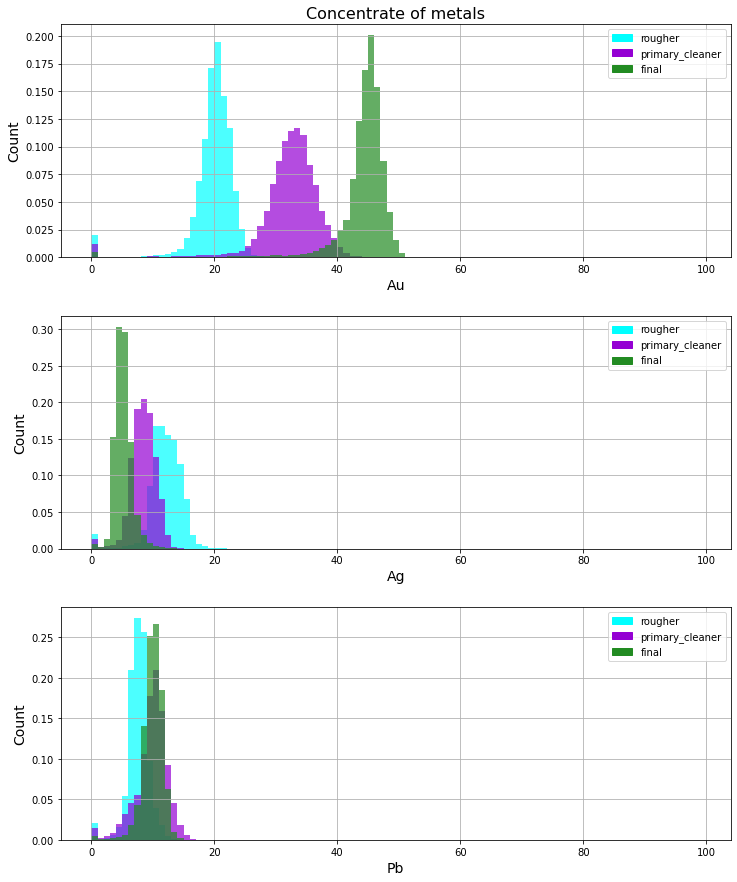

In [25]:
ALPHA = 0.7
BINS  = range(100)
COLORS = ['aqua', 'darkviolet', 'forestgreen']

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(12, 15)
ax[0].set_title(f"Concentrate of metals", fontsize=16)

patches = []
for clmn, color in zip(au_concentrate_columns, COLORS):
    ax[0].hist(data_full[clmn], density=True, color=color, bins=BINS, alpha=ALPHA)
    patches.append(mpatches.Patch(color=color, label=clmn.split('.')[0]))
ax[0].grid(True)
ax[0].set_xlabel(f"Au", fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].legend(handles=patches, loc='upper right')

for clmn, color in zip(ag_concentrate_columns, COLORS):
    ax[1].hist(data_full[clmn], density=True, color=color, bins=BINS, alpha=ALPHA)
ax[1].grid(True)
ax[1].set_xlabel(f"Ag", fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)
ax[1].legend(handles=patches, loc='upper right')

for clmn, color in zip(pb_concentrate_columns, COLORS):
    ax[2].hist(data_full[clmn], density=True, color=color, bins=BINS, alpha=ALPHA)
ax[2].grid(True)
ax[2].set_xlabel(f"Pb", fontsize=14)
ax[2].set_ylabel('Count', fontsize=14)
ax[2].legend(handles=patches, loc='upper right')

plt.subplots_adjust(hspace=0.25)
plt.show()

Заметим выбросы в виде нулевых значений концентрации на различных этапах.

<a id="concentrate_au"></a>
#### Au - золото

In [26]:
data_full.loc[:,au_concentrate_columns].describe()

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19439.000000,19439.000000,19439.000000
mean,19.772000,32.119400,44.076513
std,3.753600,5.627611,5.129784
min,0.000000,0.000000,0.000000
25%,18.802523,30.463140,43.402215
50%,20.280214,32.841295,45.011244
75%,21.717843,35.048006,46.275313
max,28.824507,45.933934,52.756638


<a id="concentrate_ag"></a>
#### Ag - серебро

In [27]:
data_full.loc[:,ag_concentrate_columns].describe()

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,19439.000000,19439.000000,19439.000000
mean,11.994759,8.442408,5.168387
std,2.733862,2.054465,1.372362
min,0.000000,0.000000,0.000000
25%,10.628337,7.263288,4.251000
50%,12.098115,8.507298,5.066039
75%,13.736996,9.809001,5.895401
max,24.480271,16.081632,16.001945


<a id="concentrate_pb"></a>
#### Pb - свинец

In [28]:
data_full.loc[:,pb_concentrate_columns].describe()

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,19439.000000,19439.000000,19439.000000
mean,7.606272,9.799976,9.978821
std,1.796757,2.593366,1.669228
min,0.000000,0.000000,0.000000
25%,6.725987,8.671652,9.137225
50%,7.742580,10.140198,10.102264
75%,8.565199,11.416016,11.035644
max,13.617072,17.081278,17.031899


### Вывод
* На каждом этапе очистки повышается доля содержания золота в руде
* Доля серебра на каждом этапе немного уменьшается
* Доля свинца после первого этапа очистки немного увеличивается, на втором этапе очистки почти не изменяется

<a id="feed_size"></a>
### 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

In [29]:
feed_sizes = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

**Размеры гранул сырья на обучающей выборке**

In [30]:
data_train.loc[:,feed_sizes].describe()

,rougher.input.feed_size,primary_cleaner.input.feed_size
count,15541.000000,15541.000000
mean,60.608697,7.302850
std,26.774241,0.610915
min,9.659576,1.080000
25%,48.278238,6.930000
50%,54.933824,7.280000
75%,66.107290,7.670000
max,484.967466,10.470000


**Размеры гранул сырья на тестовой выборке**

In [31]:
data_test.loc[:,feed_sizes].describe()

,rougher.input.feed_size,primary_cleaner.input.feed_size
count,5383.000000,5383.000000
mean,56.338644,7.268670
std,21.836788,0.610441
min,0.046369,5.650000
25%,43.913766,6.892500
50%,50.924232,7.250000
75%,62.364984,7.600000
max,477.445473,15.500000


**Построим сводный график распределения размеров гранулв в тренировочной и тестовой выборке**

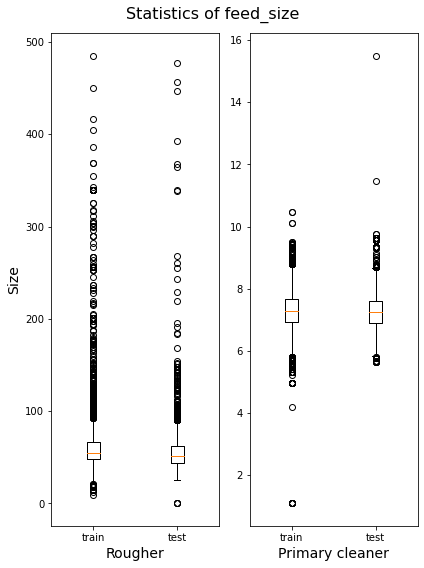

In [32]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(6,8)
fig.suptitle('Statistics of feed_size', fontsize=16)
ax[0].set_ylabel('Size', fontsize=14)
ax[0].set_xlabel('Rougher', fontsize=14)
ax[0].boxplot([data_train['rougher.input.feed_size'], data_test['rougher.input.feed_size']], labels=['train','test'])
ax[1].set_xlabel('Primary cleaner', fontsize=14)
ax[1].boxplot([data_train['primary_cleaner.input.feed_size'], data_test['primary_cleaner.input.feed_size']], labels=['train','test'])
plt.tight_layout()
plt.show()

**Построим график распределения размеров гранул**

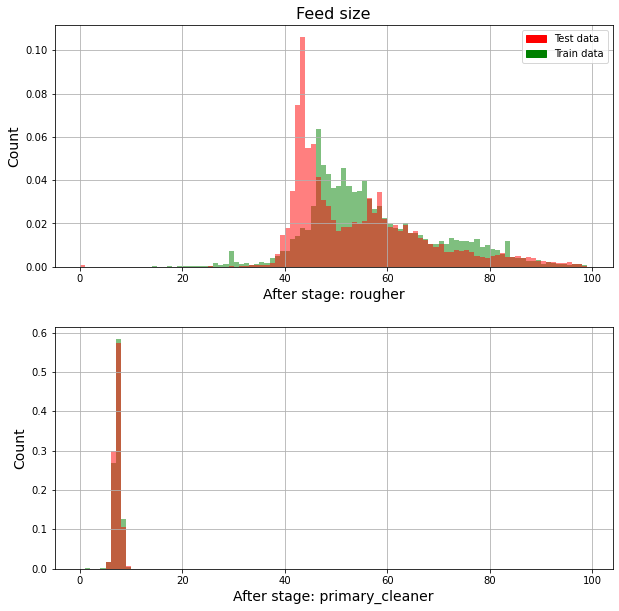

In [33]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 10)
ax[0].set_title(f"Feed size", fontsize=16)
green_patch = mpatches.Patch(color='green', label='Train data')
red_patch = mpatches.Patch(color='red', label='Test data')
ax[0].legend(handles=[red_patch, green_patch])

for i, clmn in zip(range(len(feed_sizes)), feed_sizes):
    ax[i].hist(data_train[clmn], bins=range(100), density=True, color='g', alpha=0.5)
    ax[i].hist(data_test[clmn], bins=range(100), density=True, color='r', alpha=0.5)
    ax[i].grid(True)
    ax[i].set_xlabel(f"After stage: {clmn.split('.')[0]}", fontsize=14)
    ax[i].set_ylabel('Count', fontsize=14)

plt.subplots_adjust(hspace=0.25)
plt.show()

### Вывод
* Существенных отличий гранул сырья в обучающей и тестовой выборе не выявлено, но на графике распределения размеров гранул после флотации мы видим, что на тестовой выборке при средних значениях размеров гранул наблюдается аномально малое количество данных, что может повлиять на оценку качества модели на тестовой выборке.
* Для более глубокого анализа необходимо провести проверку гипотезы об отличии гранул сырья

<a id="sum"></a>
### 2.3 Суммарная концентрация всех веществ на разных стадиях

In [34]:
def plot_sum_concentrate_hist(data=None, columns=None, bins=None):
    '''Plot histogram of sum of selected columns.'''
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10, 4)
    
    ax.set_title(f"Concentrate of all minerals on stage: {columns[0].split('.')[0]}", fontsize=16)
    ax.hist(data[columns].sum(axis=1), bins=range(bins), color='forestgreen')
    ax.grid(True)
    ax.set_xlabel("Sum of minerals concentrate", fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

    plt.subplots_adjust(hspace=0.25)
    plt.show()

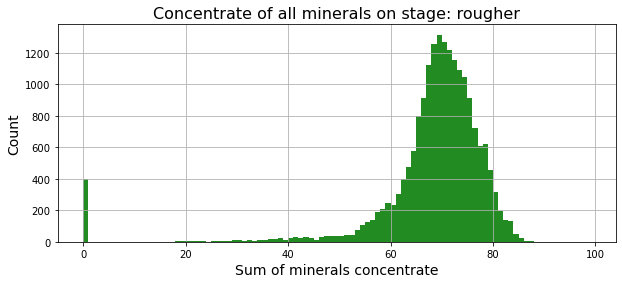

In [35]:
all_mineralls_concentrate_columns_rougher = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
plot_sum_concentrate_hist(data_full, all_mineralls_concentrate_columns_rougher, 100)

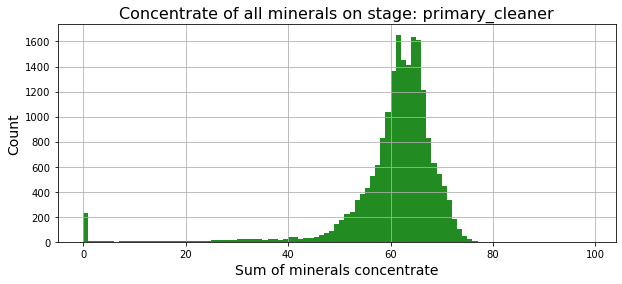

In [36]:
all_mineralls_concentrate_columns_primary_cleaner = ['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol']
plot_sum_concentrate_hist(data_full, all_mineralls_concentrate_columns_primary_cleaner, 100)

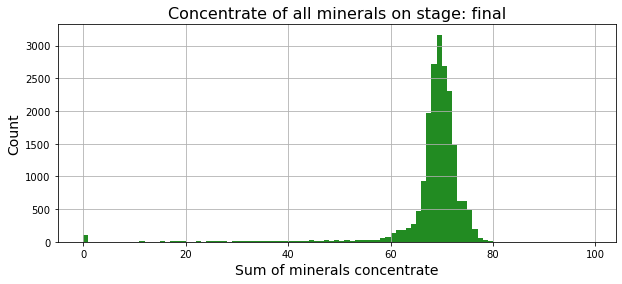

In [37]:
all_mineralls_concentrate_columns_final = ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol']
plot_sum_concentrate_hist(data_full, all_mineralls_concentrate_columns_final, 100)

<a id="model"></a>
## 3. Построение модели

<a id="smape"></a>
### 3.1 Вычисление метрики sMAPE

Создадим функцию расчёта sMAPE для одного целевого признака и для комбинации двух целевых признаков

In [38]:
def smape(y_true, y_pred):
    '''Returns sMAPE in percents'''
    score = ((sum((abs(y_true - y_pred)) / ((abs(y_true) + abs(y_pred)) / 2))) / len(y_true)) * 100
    # check wrong values
    return score
    
def smape_full(smape_rougher, smape_final):
    '''Returns sMAPE of rought and final recovery in percents'''
    return (0.25*smape_rougher + 0.75*smape_final)

Создадим класс расчёта метрики sMAPE для модели CatBoost

In [39]:
class sMapeMetric(object):
        
    #@staticmethod
    #def smape_(y_true, y_pred):
    #    '''Returns sMAPE in percents'''
    #    return ((sum((abs(y_true - y_pred)) / ((abs(y_true) + abs(y_pred)) / 2))) / len(y_true)) * 100
    
    def get_final_error(self, error, weight):
        return error
    def is_max_optimal(self):
        return False # Lower  values are better than higher values
    def evaluate(self, approxes, target, weight=None):
        # approxes - list of list-like objects (one object per approx dimension)
        # target - list-like object
        # weight - list-like object, can be None
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        score = smape(approx, target)

        return score, 0

Создадим объект расчёта sMAPE для передачи в модели из Scikit-learn

In [40]:
smape_scorer = metrics.make_scorer(smape, greater_is_better=False)

<a id="fit"></a>
### 3.2 Обучение и выбор модели

**Разделим тренировочную выборку на признаки и целевые признаки**

Для обучения модели прогноза после этапа флотации используем только данные на этапе флотации, а для обучения модели прогноза на финальном этапе используем только данные после этапа флотации.

In [41]:
rougher_columns = list(filter(lambda x: 'rougher' in x, data_test.columns.tolist()))
final_columns = list(set(data_test.columns)-set(rougher_columns))
features_rough_train = data_train[rougher_columns]
features_final_train = data_train[final_columns]
target_rough_train = data_train['rougher.output.recovery']
target_final_train = data_train['final.output.recovery']

**Создадим функцию для добавления результатов работы моделей**

In [42]:
SEED = 91
CV_FOLDS = 5
THREADS = 3

In [43]:
results_rougher = {'name': [], 'model':[], 'grid':[], 'cv_smape':[]}
results_final = {'name': [], 'model':[], 'grid':[], 'cv_smape':[]}

def add_model_result(results, name, model, grid, mae):
    results['name'].append(name)
    results['model'].append(model)
    results['grid'].append(grid)
    results['cv_smape'].append(mae)

**Создадим функцию для работы с Grid Search**

In [44]:
def generate_clf(X, y, model, parameters):
    clf = model_selection.GridSearchCV(
            model,
            parameters,
            cv=CV_FOLDS,
            scoring=smape_scorer,
            return_train_score=False, 
            n_jobs=THREADS)
    clf.fit(X, y)
    return clf.best_estimator_, -clf.best_score_, clf

In [45]:
model_params = {
    'SVM': {
        'model': svm.SVR(),
        'params' : {
            'kernel': ('linear', 'rbf'),
            'C': (5, 10, 15)#,
            #'epsilon': (0.1, 0.5, 1.0),
        }  
    }#,

#    'Desicion Tree': {
#        'model': tree.DecisionTreeRegressor(criterion='mae', random_state=SEED), 
#        'params' : {
#            'max_depth': (7,9,11,13)
#        }  
#    }
}

### Обучим и сравним модели предсказания коэффициента восстановления на этапе флотации 'rougher.output.recovery'

In [46]:
features_train = features_rough_train
target_train = target_rough_train

#### Масштабируем данные
Некоторые модели чувствительны к значениям, поэтому необходимо произвести масштабирование.
Используем StandardScaler как подходящий алгоритм на наших данных без ярко выраженных выбросов и распределению близкому к нормальному.

In [47]:
scaler_rough = preprocessing.StandardScaler()
features_train = scaler_rough.fit_transform(features_train)

**Используем как модель предсказание среднего значения**

In [48]:
# dummy regressor
smape_score = smape(target_train, target_train.mean())
add_model_result(results_rougher, 'dummy_mean', target_train.mean(), None, smape_score)
print(f'sMAPE на моделе предсказывающей среднее значение: {smape_score}')

sMAPE на моделе предсказывающей среднее значение: 83.05855365910013


**Grid Search**

In [49]:
for model_name, mp in model_params.items():
    print(model_name)
    start = tm.time()
    model, smape_score, clf = generate_clf(features_train, target_train, mp['model'], mp['params'])
    add_model_result(results_rougher, model_name, model, clf, smape_score)
    print(f"sMAPE: {smape_score}")
    print(f"Fit time: {(tm.time() - start):.0f}s\n")

SVM
sMAPE: 14.20074467141373
Fit time: 121s



**CatBoost**

Try use custom metric

In [50]:
catboost_params = {
    'loss_function': 'MAE',
    #'eval_metric': sMapeMetric(),
    'eval_metric': 'SMAPE',
    'learning_rate': 0.01,
    'iterations': 2000,
    'early_stopping_rounds': 50,
    #'verbose': 200,
    'silent': True,
    'thread_count': THREADS,
    'random_seed': SEED
}

grid_catboost = {
    'depth': [4, 5, 6, 7],
    'l2_leaf_reg': [3, 5, 7]
}

In [51]:
%%time

model = CatBoostRegressor(**catboost_params)

grid_search_result = model.grid_search(grid_catboost, 
                                        X=features_train, 
                                        y=target_train,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.24329312
bestIteration = 490

0:	loss: 12.2432931	best: 12.2432931 (0)	total: 1.19s	remaining: 13.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.23681289
bestIteration = 490

1:	loss: 12.2368129	best: 12.2368129 (1)	total: 2.27s	remaining: 11.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.18806006
bestIteration = 561

2:	loss: 12.1880601	best: 12.1880601 (2)	total: 3.46s	remaining: 10.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.13405486
bestIteration = 716

3:	loss: 12.1340549	best: 12.1340549 (3)	total: 5.22s	remaining: 10.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.08427916
bestIteration = 666

4:	loss: 12.0842792	best: 12.0842792 (4)	total: 6.87s	remaining: 9.62s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.00827157
bestIteration = 707

5:	loss: 12.0082716	best: 12.0082716 (5)	total: 8.6

In [52]:
model.fit(features_train, target_train)

#smape_score = grid_search_result['cv_results']['test-sMapeMetric-mean'][-1]
smape_score = grid_search_result['cv_results']['test-SMAPE-mean'][-1]

add_model_result(results_rougher, 'CatBoost', model, grid_search_result, smape_score)
print(f"Model: {grid_search_result['params']}")
print(f'sMAPE (rougher): {smape_score}')

Model: {'depth': 6, 'l2_leaf_reg': 3}
sMAPE (rougher): 11.865940469951942


In [53]:
feature_importance_df = pd.DataFrame(model.feature_importances_, index=rougher_columns, columns=['importance'])
feature_importance_df.sort_values('importance')

,importance
rougher.state.floatbank10_d_level,0.100178
rougher.state.floatbank10_e_level,0.292582
rougher.state.floatbank10_b_level,0.367372
rougher.input.floatbank10_sulfate,0.532606
rougher.state.floatbank10_b_air,0.984158
rougher.state.floatbank10_d_air,1.131228
rougher.state.floatbank10_f_level,1.381329
rougher.state.floatbank10_c_air,2.022428
rougher.state.floatbank10_a_level,2.123586
rougher.state.floatbank10_e_air,2.304545


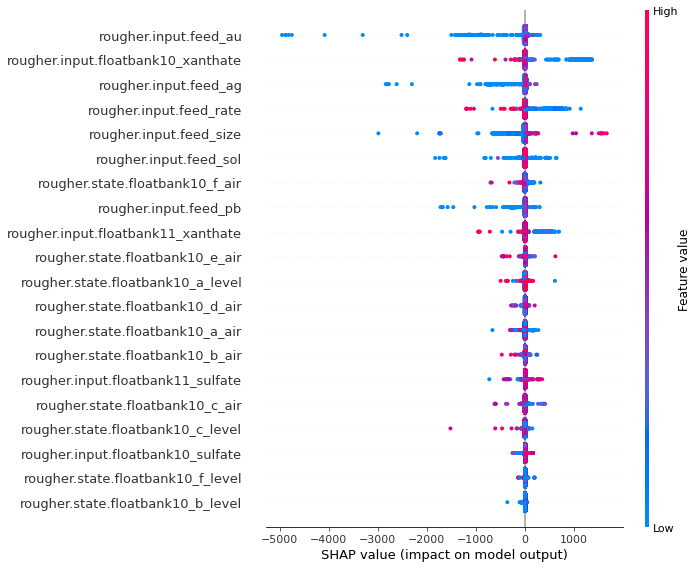

In [54]:
train_data = Pool(data=features_train,
                  label=target_train
                 )
                 
explainer = shap.TreeExplainer(model) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object
shap.summary_plot(shap_values, features_train, feature_names=rougher_columns)

In [55]:
pd.DataFrame(results_rougher).sort_values('cv_smape')

,name,model,grid,cv_smape
2,CatBoost,<catboost.core.CatBoostRegressor object at 0x7...,"{'params': {'depth': 6, 'l2_leaf_reg': 3}, 'cv...",11.865940
1,SVM,SVR(C=5),"GridSearchCV(cv=5, estimator=SVR(), n_jobs=3,\...",14.200745
0,dummy_mean,36.547247,None,83.058554


Оставим только с признаки с коэффициентом важности > 1.0

In [56]:
rougher_columns = feature_importance_df.loc[feature_importance_df['importance'] > 0.5, 'importance'].index
features_train = data_train[rougher_columns]

scaler_rough = preprocessing.StandardScaler()
features_train = scaler_rough.fit_transform(features_train)

In [57]:
%%time

model, smape_score, clf = generate_clf(features_train, target_train, model_params['SVM']['model'], model_params['SVM']['params'])
add_model_result(results_rougher, 'SVM_2', model, clf, smape_score)

CPU times: user 7.75 s, sys: 55.2 ms, total: 7.8 s
Wall time: 1min 55s


In [58]:
%%time

model = CatBoostRegressor(**catboost_params)

grid_search_result = model.grid_search(grid_catboost, 
                                        X=features_train, 
                                        y=target_train,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.3163468
bestIteration = 499

0:	loss: 12.3163468	best: 12.3163468 (0)	total: 1.1s	remaining: 12.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.31571285
bestIteration = 499

1:	loss: 12.3157128	best: 12.3157128 (1)	total: 2.12s	remaining: 10.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.31771857
bestIteration = 499

2:	loss: 12.3177186	best: 12.3157128 (1)	total: 3.14s	remaining: 9.43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.53036481
bestIteration = 896

3:	loss: 11.5303648	best: 11.5303648 (3)	total: 5.19s	remaining: 10.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.77769988
bestIteration = 704

4:	loss: 11.7776999	best: 11.5303648 (3)	total: 6.81s	remaining: 9.53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.48088101
bestIteration = 930

5:	loss: 11.4808810	best: 11.4808810 (5)	total: 9.15s

In [59]:
model.fit(features_train, target_train)

#smape_score = grid_search_result['cv_results']['test-sMapeMetric-mean'][-1]
smape_score = grid_search_result['cv_results']['test-SMAPE-mean'][-1]

add_model_result(results_rougher, 'CatBoost_2', model, grid_search_result, smape_score)
print(f"Model: {grid_search_result['params']}")
print(f'sMAPE (rougher): {smape_score}')

Model: {'depth': 5, 'l2_leaf_reg': 7}
sMAPE (rougher): 11.651432429782952


In [60]:
feature_importance_df = pd.DataFrame(model.feature_importances_, index=rougher_columns)
feature_importance_df.sort_values(0)

,0
rougher.state.floatbank10_f_level,0.102981
rougher.state.floatbank10_b_air,0.560709
rougher.input.floatbank11_sulfate,0.853172
rougher.state.floatbank10_f_air,0.882632
rougher.state.floatbank10_d_air,0.967910
rougher.state.floatbank10_a_air,1.625688
rougher.state.floatbank10_c_level,2.745230
rougher.state.floatbank10_a_level,2.898508
rougher.state.floatbank10_c_air,2.924057
rougher.state.floatbank10_e_air,3.248384


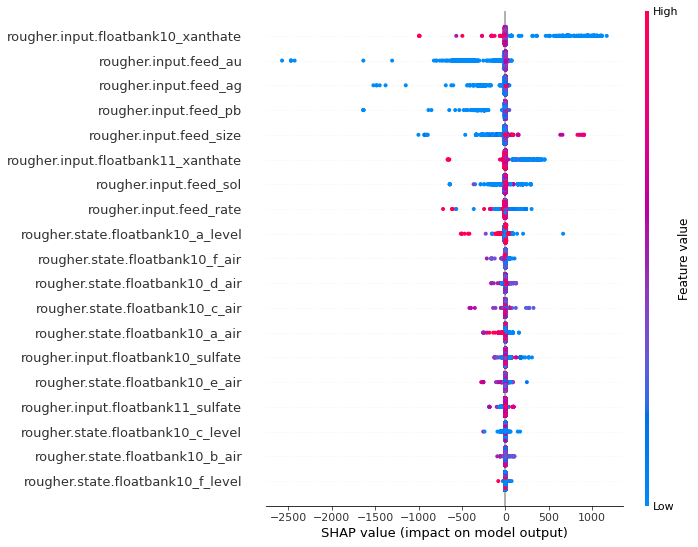

In [61]:
train_data = Pool(data=features_train,
                  label=target_train
                 )
                 
explainer = shap.TreeExplainer(model) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object
shap.summary_plot(shap_values, features_train, feature_names=rougher_columns)

**Итоговые результаты моделей для оценки коэффициента восстановления на этапе флотации**

In [62]:
results_rougher = pd.DataFrame(results_rougher).sort_values('cv_smape')
results_rougher

,name,model,grid,cv_smape
4,CatBoost_2,<catboost.core.CatBoostRegressor object at 0x7...,"{'params': {'depth': 5, 'l2_leaf_reg': 7}, 'cv...",11.651432
2,CatBoost,<catboost.core.CatBoostRegressor object at 0x7...,"{'params': {'depth': 6, 'l2_leaf_reg': 3}, 'cv...",11.865940
3,SVM_2,SVR(C=5),"GridSearchCV(cv=5, estimator=SVR(), n_jobs=3,\...",13.953662
1,SVM,SVR(C=5),"GridSearchCV(cv=5, estimator=SVR(), n_jobs=3,\...",14.200745
0,dummy_mean,36.547247,None,83.058554


### Обучим и сравним модели предсказания коэффициента восстановления после очистки руды 'final.output.recovery'

In [63]:
features_train = features_final_train
target_train = target_final_train

In [64]:
scaler_final = preprocessing.StandardScaler()
features_train = scaler_final.fit_transform(features_train)

In [65]:
# dummy regressor
smape_score = smape(target_train, target_train.mean())
add_model_result(results_final, 'dummy_mean', target_train.mean(), None, smape_score)
print(f'sMAPE на моделе предсказывающей среднее значение: {smape_score}')

sMAPE на моделе предсказывающей среднее значение: 58.94105658823538


In [66]:
for model_name, mp in model_params.items():
    print(model_name)
    start = tm.time()
    model, smape_score, clf = generate_clf(features_train, target_train, mp['model'], mp['params'])
    add_model_result(results_final, model_name, model, clf, smape_score)
    print(f"sMAPE: {smape_score}")
    print(f"Fit time: {(tm.time() - start):.0f}s\n")

SVM
sMAPE: 14.760646616614782
Fit time: 141s



In [67]:
%%time

model = CatBoostRegressor(**catboost_params)

grid_search_result = model.grid_search(grid_catboost, 
                                        X=features_train, 
                                        y=target_train,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.62632745
bestIteration = 1337

0:	loss: 10.6263275	best: 10.6263275 (0)	total: 3.01s	remaining: 33.1s

bestTest = 10.27413164
bestIteration = 1999

1:	loss: 10.2741316	best: 10.2741316 (1)	total: 7.24s	remaining: 36.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.45451922
bestIteration = 1621

2:	loss: 10.4545192	best: 10.2741316 (1)	total: 10.7s	remaining: 32.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.84791127
bestIteration = 1270

3:	loss: 10.8479113	best: 10.2741316 (1)	total: 14.1s	remaining: 28.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.93258545
bestIteration = 943

4:	loss: 10.9325855	best: 10.2741316 (1)	total: 16.6s	remaining: 23.3s

bestTest = 10.42499297
bestIteration = 1999

5:	loss: 10.4249930	best: 10.2741316 (1)	total: 21.7s	remaining: 21.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.22464855
bestI

In [68]:
model.fit(features_train, target_train)

#smape_score = grid_search_result['cv_results']['test-sMapeMetric-mean'][-1]
smape_score = grid_search_result['cv_results']['test-SMAPE-mean'][-1]

add_model_result(results_final, 'CatBoost', model, grid_search_result, smape_score)

print(f"Model: {grid_search_result['params']}")
print(f'sMAPE (final): {smape_score}')

Model: {'depth': 4, 'l2_leaf_reg': 5}
sMAPE (final): 10.968917700030337


In [69]:
feature_importance_df = pd.DataFrame(model.feature_importances_, index=final_columns, columns=['importance'])
feature_importance_df.sort_values('importance')

,importance
primary_cleaner.state.floatbank8_c_air,0.002830
secondary_cleaner.state.floatbank4_b_air,0.003972
secondary_cleaner.state.floatbank5_a_air,0.005626
secondary_cleaner.state.floatbank3_b_level,0.016153
secondary_cleaner.state.floatbank3_a_level,0.021178
secondary_cleaner.state.floatbank5_a_level,0.025895
secondary_cleaner.state.floatbank2_b_level,0.032523
primary_cleaner.state.floatbank8_d_air,0.035133
secondary_cleaner.state.floatbank5_b_air,0.067020
secondary_cleaner.state.floatbank2_b_air,0.072522


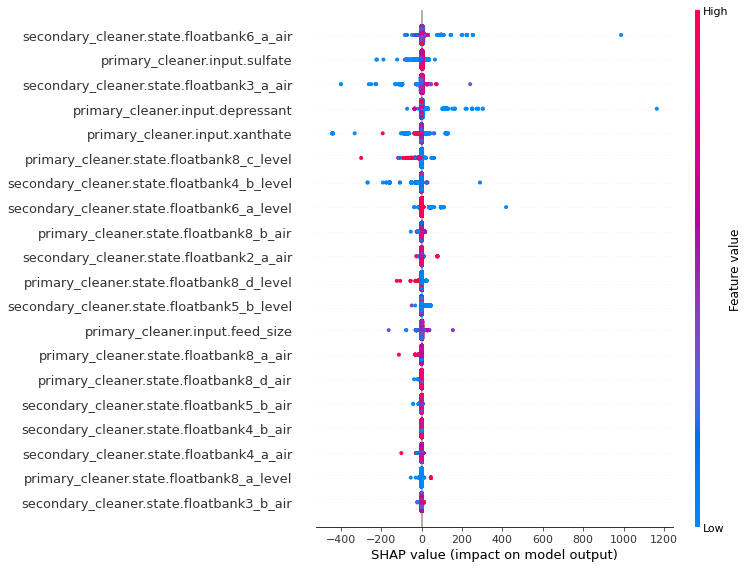

In [70]:
train_data = Pool(data=features_train,
                  label=target_train
                 )
                 
explainer = shap.TreeExplainer(model) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object
shap.summary_plot(shap_values, features_train, feature_names=final_columns)

In [71]:
pd.DataFrame(results_final).sort_values('cv_smape')

,name,model,grid,cv_smape
2,CatBoost,<catboost.core.CatBoostRegressor object at 0x7...,"{'params': {'depth': 4, 'l2_leaf_reg': 5}, 'cv...",10.968918
1,SVM,SVR(C=5),"GridSearchCV(cv=5, estimator=SVR(), n_jobs=3,\...",14.760647
0,dummy_mean,37.519129,None,58.941057


In [72]:
final_columns = feature_importance_df.loc[feature_importance_df['importance'] > 0.5, 'importance'].index
features_train = data_train[final_columns]

scaler_final = preprocessing.StandardScaler()
features_train = scaler_final.fit_transform(features_train)

In [73]:
%%time

model, smape_score, clf = generate_clf(features_train, target_train, model_params['SVM']['model'], model_params['SVM']['params'])
add_model_result(results_final, 'SVM_2', model, clf, smape_score)

CPU times: user 15.3 s, sys: 42.4 ms, total: 15.3 s
Wall time: 1min 48s


In [74]:
%%time

model = CatBoostRegressor(**catboost_params)

grid_search_result = model.grid_search(grid_catboost, 
                                        X=features_train, 
                                        y=target_train,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.69776876
bestIteration = 1288

0:	loss: 10.6977688	best: 10.6977688 (0)	total: 2.27s	remaining: 24.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.93512091
bestIteration = 937

1:	loss: 10.9351209	best: 10.6977688 (0)	total: 3.93s	remaining: 19.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.18866868
bestIteration = 742

2:	loss: 11.1886687	best: 10.6977688 (0)	total: 5.25s	remaining: 15.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.53300618
bestIteration = 1746

3:	loss: 10.5330062	best: 10.5330062 (3)	total: 8.73s	remaining: 17.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.58378411
bestIteration = 1620

4:	loss: 10.5837841	best: 10.5330062 (3)	total: 11.9s	remaining: 16.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.76158266
bestIteration = 1158

5:	loss: 10.7615827	best: 10.5330062 (3)	total:

In [75]:
model.fit(features_train, target_train)

#smape_score = grid_search_result['cv_results']['test-sMapeMetric-mean'][-1]
smape_score = grid_search_result['cv_results']['test-SMAPE-mean'][-1]

add_model_result(results_final, 'CatBoost_2', model, grid_search_result, smape_score)
print(f"Model: {grid_search_result['params']}")
print(f'sMAPE (final): {smape_score}')

Model: {'depth': 5, 'l2_leaf_reg': 3}
sMAPE (final): 11.42865011661496


In [76]:
feature_importance_df = pd.DataFrame(model.feature_importances_, index=final_columns, columns=['importance'])
feature_importance_df.sort_values('importance')

,importance
secondary_cleaner.state.floatbank4_b_level,0.112899
secondary_cleaner.state.floatbank6_a_level,0.348868
primary_cleaner.state.floatbank8_d_level,1.481171
primary_cleaner.input.feed_size,1.812683
secondary_cleaner.state.floatbank2_a_air,3.296442
primary_cleaner.state.floatbank8_a_air,4.349050
primary_cleaner.state.floatbank8_c_level,5.738922
primary_cleaner.input.sulfate,8.148480
secondary_cleaner.state.floatbank4_a_air,9.501775
secondary_cleaner.state.floatbank3_a_air,11.708653


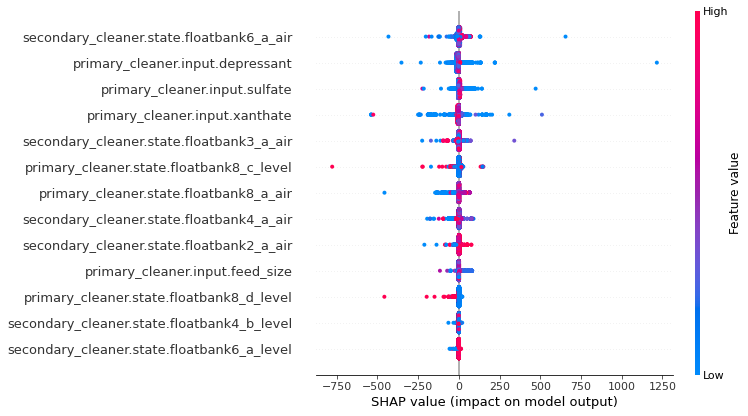

In [77]:
train_data = Pool(data=features_train,
                  label=target_train
                 )
                 
explainer = shap.TreeExplainer(model) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object
shap.summary_plot(shap_values, features_train, feature_names=final_columns)

**Итоговые результаты моделей для оценки коэффициента восстановления после этапов очистки**

In [78]:
results_final = pd.DataFrame(results_final).sort_values('cv_smape')
results_final

,name,model,grid,cv_smape
2,CatBoost,<catboost.core.CatBoostRegressor object at 0x7...,"{'params': {'depth': 4, 'l2_leaf_reg': 5}, 'cv...",10.968918
4,CatBoost_2,<catboost.core.CatBoostRegressor object at 0x7...,"{'params': {'depth': 5, 'l2_leaf_reg': 3}, 'cv...",11.428650
1,SVM,SVR(C=5),"GridSearchCV(cv=5, estimator=SVR(), n_jobs=3,\...",14.760647
3,SVM_2,"SVR(C=10, kernel='linear')","GridSearchCV(cv=5, estimator=SVR(), n_jobs=3,\...",14.776978
0,dummy_mean,37.519129,None,58.941057


### Вывод
* для предсказания двух целевых признаков обучали модели на разных признаках
* выявили, что некоторые признаки не влияют на результаты предсказания модели

<a id="test"></a>
### 3.3 Проверка модели на тестовой выборке

Получим недостающие столбцы в тестовой выборке из полного датасета и посчитаем значение sMAPE на тестовой выборке

In [79]:
features_rough_test = data_test.loc[data_test.index.intersection(data_full.index), rougher_columns]
features_final_test = data_test.loc[data_test.index.intersection(data_full.index), final_columns]
target_rough_test = data_full.loc[data_test.index.intersection(data_full.index), 'rougher.output.recovery']
target_final_test = data_full.loc[data_test.index.intersection(data_full.index), 'final.output.recovery']

features_rough_test = scaler_rough.transform(features_rough_test)
features_final_test = scaler_final.transform(features_final_test)

predicted_rough_test = results_rougher.loc[results_rougher['name'] == 'CatBoost_2','model'].iloc[0].predict(features_rough_test)
predicted_final_test = results_final.loc[results_final['name'] == 'CatBoost_2','model'].iloc[0].predict(features_final_test)
smape_test = (0.25*smape(target_rough_test, predicted_rough_test) \
            + 0.75*smape(target_final_test, predicted_final_test))

print('sMAPE:', smape_test)

sMAPE: 11.104213184005673


<a id="conclusion"></a>
## 4. Общий вывод
**Подготовили и проанализировали данные. Выявленные пропуски в данных по возможности заменили предыдущим значением по времени исходя из предположения, что значения близкие по времени не должны сильно отличаться. Выявленные аномалии в виде нулевых значений удалили из тренировочной выборки. Выбрали наилучшую модель модель предсказания значения recovery по метрике sMAPE, применив метод кросс-валидации, и проверили полученную модель на тестовой выборке. Получили итоговое значение sMAPE = 11.**

**Данную модель можно использовать для предсказания эффективности восстановления золота из золотосодержащей руды.**

**Рекомендуется проверять значения на выбросы и аномальность перед подачей на модель предсказания.**